In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam
import PIL
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

**Downloading Dataset**

I have uploaded dataset of all images to github to make it easier to work with Colab.

In [ ]:
!wget https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/dataset_reduced.zip?raw=true  -O data.zip
!unzip data.zip

--2021-05-13 20:42:47--  https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/dataset_reduced.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/raw/master/dataset_reduced.zip [following]
--2021-05-13 20:42:48--  https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/raw/master/dataset_reduced.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/master/dataset_reduced.zip [following]
--2021-05-13 20:42:48--  https://raw.githubusercontent.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/master/dataset_reduced.zip
Resolving raw

Loading the datasets into the variables

In [ ]:
SIZE_X = int(1024 / 8)
SIZE_Y = int(768 / 8)

x = np.load( "train_images_small.npy")
x = x.reshape(2935, SIZE_Y, SIZE_X, 1)
y = np.load('keypoints_small.npy')

metadeta = pd.read_csv('metadeta.csv')
print(x.shape)
data_size = x.shape[0] #number of images

augmented_meta_deta = {'subj' : [], 'augmented' : []}

(2935, 96, 128, 1)


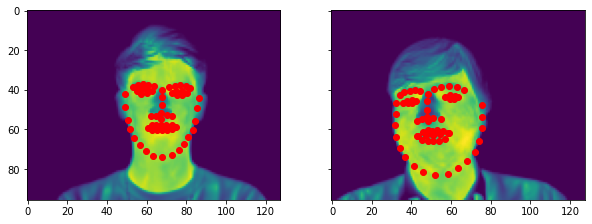

In [ ]:
import random 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=[10,10])
n1 = random.randint(0, 2900)
img = np.reshape(x[n1], (SIZE_Y, SIZE_X))
points = y[n1]
x_s = np.take(points, [i for i in range(len(points)) if not i % 2])
y_s = np.take(points, [i for i in range(len(points)) if i % 2])
ax[0].imshow(img)
ax[0].scatter(y_s, x_s, color = 'r')
n1 = random.randint(0, 2900)
img = np.reshape(x[n1], (SIZE_Y, SIZE_X))
points = y[n1]
x_s = np.take(points, [i for i in range(len(points)) if not i % 2])
y_s = np.take(points, [i for i in range(len(points)) if i % 2])
ax[1].imshow(img)
ax[1].scatter(y_s, x_s, color = 'r')

plt.show()

defining functions to augment the data. Augmenting means to produce more images from the images already in the dataset. More [here](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/).

The function `translate` takes an image changes the position of the object on the image. Amount of change is choosen randomly from the dataset. We also change the bounding box of the image. We do this so that the model does not assume that all the faces occur at the center of the image.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random



def translate(image, predicted, show = False):
  new_pred = np.copy(predicted)
  
  x_s = np.take(new_pred, [i for i in range(len(new_pred)) if (i % 2) == 1 ])
  y_s = np.take(new_pred, [i for i in range(len(new_pred)) if (i % 2) == 0])

  start_x = int(min(x_s) * 0.9)
  start_y = int(min(y_s) * 0.9)
  end_x = int(max(x_s) * 0.9)
  end_y = int(max(y_s) * 0.9)

  new_x = random.randint(-start_x , SIZE_X - end_x)
  new_y = random.randint(-start_y , SIZE_Y - end_y)

  image = np.reshape(image, (SIZE_Y, SIZE_X))

  translation_matrix = np.float32([ [1,0, new_x], [0,1, new_y] ])
  img_translation = cv2.warpAffine(image, translation_matrix, (SIZE_X, SIZE_Y))



  new_pred = np.array(list(np.clip(x_s + new_x, 0, SIZE_X)) + list(np.clip(y_s + new_y, 0, SIZE_Y))) 

  if show:
    fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=[10,10])
    ax[0].imshow(image)
    ax[1].imshow(img_translation)
    ax[0].scatter(x_s, y_s)
    ax[1].scatter(new_pred[:68], new_pred[68:])


    plt.show()
  return np.reshape(img_translation, (SIZE_Y, SIZE_X, 1)), new_pred

The  `scale` function zooms in and out of the image, we do this so that the model does not assume that all faces have the same size. 

In [ ]:
def scale(image, predicted, show = False):
  image = np.reshape(image, (SIZE_Y, SIZE_X))
  img_shape = image.shape
  canvas = np.zeros(img_shape, dtype = np.uint8)

  scale = random.uniform(-0.5, 0.5)
  resize_scale_x = 1 + scale
  resize_scale_y = 1 + scale
 
  img=  cv2.resize(image, None, fx = resize_scale_x, fy = resize_scale_y)
  new_pred = np.copy(predicted)

  y_lim = int(min(resize_scale_y,1)*img_shape[0])
  x_lim = int(min(resize_scale_x,1)*img_shape[1])

  canvas[:y_lim,:x_lim] =  img[:y_lim,:x_lim]

  img = canvas

  x_s = np.take(new_pred, [i for i in range(len(new_pred)) if (i % 2) == 1 ])
  y_s = np.take(new_pred, [i for i in range(len(new_pred)) if (i % 2) == 0])

  new_pred = np.array(list(np.clip(x_s * resize_scale_x, 0, SIZE_X)) + list(np.clip(y_s * resize_scale_x, 0, SIZE_Y))) 

  if show:
    fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=[10,10])
    ax[0].imshow(image)
    ax[1].imshow(canvas)
    ax[0].scatter(x_s, y_s)
    ax[1].scatter(new_pred[:68], new_pred[68:])

    plt.show()

  return np.reshape(img, (SIZE_Y, SIZE_X, 1)), new_pred


Augments the dataset by adding 4 new images for every image in the dataset. We keep the subject ID preserved. 4 new images are added by randomly decided whether to call `translate` or `scale` function.

In [ ]:
augmented_x = np.zeros((data_size * 5, SIZE_Y, SIZE_X, 1))
augmented_y = np.zeros((data_size * 5, 68 * 2))

n = 0
for i, row in metadeta.iterrows():
  subj = row['subj']
  augmented_x[n] = x[i]
  x_s = np.take(y[i], [i for i in range(len(y[i])) if (i % 2) == 1 ])
  y_s = np.take(y[i], [i for i in range(len(y[i])) if (i % 2) == 0])
  augmented_y[n] = np.array(list(np.clip(x_s, 0, SIZE_X)) + list(np.clip(y_s, 0, SIZE_Y)))
  n += 1
  for _ in range(4):
    show = False
    if random.random() < 0.5:
      augmented_x[n], augmented_y[n] = translate(x[i], y[i], show = show)
    else:
      pass
      augmented_x[n], augmented_y[n] = scale(x[i], y[i], show = show)
    n += 1

  augmented_meta_deta['subj'].extend([subj] * 5)
  augmented_meta_deta['augmented'].extend([0, 1, 1, 1, 1])






In [ ]:
augmented_meta_deta = pd.DataFrame.from_dict(augmented_meta_deta)
augmented_meta_deta.to_csv("augmented_metadeta.csv")
np.save('augmented_img', augmented_x)
np.save('augmented_y', augmented_y)

In [ ]:
print(augmented_y.shape)

(14675, 136)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
augmented_meta_deta.to_csv("./drive/My Drive/augmented_metadeta_KP.csv")
np.save("./drive/My Drive/augmented_metadeta_KP.csv", augmented_x)
np.save("./drive/My Drive/augmented_metadeta_KP.csv", augmented_y)

**Dividing dataset into training, validation and test set**
We load the dataset, normalize so that all values are between 0 and 1 and then divide it into train, test and validation set.

The division here is slightly different. Conventionally all the observations are divided into these sets, but here, to ensure that the model is robust and our final test has not been seen, we divide subjects into test, train and validation set. Once the sujbects have been divided, we then put all the images belonging to train subjects in train set. Following similar suite for validation and test set, except that we do not include augmented images as we want out test loss to only include original images.

In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam
import PIL
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

augmented_x = np.load('augmented_img.npy')
augmented_y = np.load('augmented_y.npy')

augmented_x /= 255 #normalzing
augmented_y[:,:68] = augmented_y[:,:68]/SIZE_X
augmented_y[:,68:] = augmented_y[:,68:]/SIZE_Y


metadeta = pd.read_csv('augmented_metadeta.csv')

subjects = (list(set(metadeta['subj'])))
n = len(subjects)
train_subjects = np.random.choice(subjects, size = int(n * 0.7), replace = False)
left_subjects = list(set(subjects) - set(train_subjects))
validation_subjects = np.random.choice(left_subjects, size = int(len(left_subjects) * 0.5), replace = False)
test_subjects = list(set(subjects) - (set(train_subjects).union(set(validation_subjects))))

train_indices = np.logical_and(np.isin(metadeta['subj'], train_subjects), True)
train_indices = [i for i in range(metadeta['subj'].shape[0]) if train_indices[i]]

train_x = np.zeros((len(train_indices), SIZE_Y, SIZE_X, 1))
train_y = np.zeros((len(train_indices), 68 * 2))
count = 0



for i in train_indices:
  train_x[count] = augmented_x[i]
  train_y[count] = augmented_y[i]
  count += 1

valid_indices = np.logical_and(np.isin(metadeta['subj'], validation_subjects), metadeta['augmented'] == 0)
valid_indices = [i for i in range(metadeta['subj'].shape[0]) if valid_indices[i]]

valid_x = np.zeros((len(valid_indices), SIZE_Y, SIZE_X, 1))
valid_y = np.zeros((len(valid_indices), 68 * 2))
count = 0

for i in valid_indices:
  valid_x[count] = augmented_x[i]
  valid_y[count] = augmented_y[i]
  count += 1

test_indices = np.logical_and(np.isin(metadeta['subj'], test_subjects), metadeta['augmented'] == 0)
test_indices = [i for i in range(metadeta['subj'].shape[0]) if test_indices[i]]

test_x = np.zeros((len(test_indices), SIZE_Y, SIZE_X, 1))
test_y = np.zeros((len(test_indices), 68 * 2))
count = 0

for i in test_indices:
  test_x[count] = augmented_x[i]
  test_y[count] = augmented_y[i]
  count += 1



print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)


(10100, 96, 128, 1)
(10100, 136)
(435, 96, 128, 1)
(435, 136)
(480, 96, 128, 1)
(480, 136)


**Sample Images from the train set**
Notice the changes for each subject

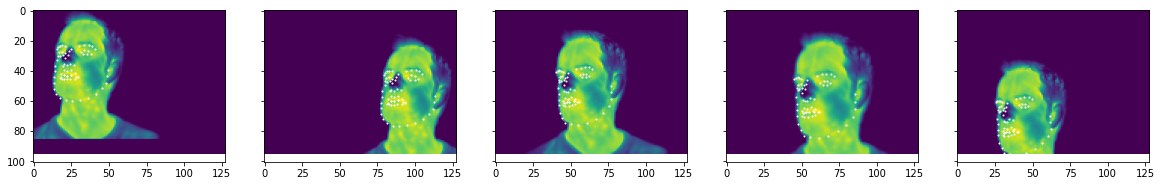

In [ ]:
  import matplotlib.pyplot as plt
  nrows = 1
  ncols = 5
  n = 2873
  irand=(np.random.choice(train_x.shape[0],nrows * ncols))
  fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[20,20])
  for row in range(nrows):
    for col in range(ncols):
      to_image = np.reshape(train_x[n], (SIZE_Y, SIZE_X)) * 255
      ax[col].imshow(to_image)
      new_pred = train_y[n]
      ax[col].scatter(new_pred[:68] * SIZE_X, new_pred[68:] * SIZE_Y, color = 'white', label = 'prediced', s = 1)
      n += 1
        
  ##plt.show()

plt.savefig('dataset_non_augmented.png')

In [ ]:
irand

array([ 2974,  2457,  2873, 10611,  6483])

(50, 50)
19.591997146606445 33.941545486450195 77.516845703125 91.73963356018066


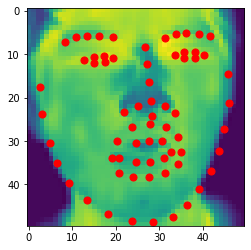

In [ ]:
## we have all the images now. We want to detect faces from them.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image


model3 = Sequential()
model3.add(Conv2D(32, (2, 2), padding = 'same', activation='tanh', input_shape=(SIZE_Y, SIZE_X, 1)))

model3.add(Conv2D(32, (2, 2), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
#model3.add(Dropout(0.5))
model3.add(Conv2D(64, (3, 3), activation='tanh'))
#model3.add(Dropout(0.5))
model3.add(Conv2D(64, (3, 3), activation='tanh'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='tanh'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(256, (3, 3), activation='tanh'))
model3.add(Conv2D(256, (5, 5), activation='relu'))
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
#model3.add(Dropout(0.5))
model3.add(Dense(4, activation='sigmoid'))

from tensorflow.keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=False, rankdir='LR')

model3.load_weights('./modelnew_augmentedData_best.h5')

#getting bboxes
predictions = [model3.predict(train_x), model3.predict(valid_x), model3.predict(test_x)]

data = [train_x, valid_x, test_x]
key_points = [np.copy(train_y), np.copy(valid_y), np.copy(test_y)]

cropped = [np.zeros((train_x.shape[0], 50, 50, 1)), np.zeros((valid_x.shape[0], 50, 50, 1)), np.zeros((test_x.shape[0], 50, 50, 1))]
cropped_keypoints = [np.zeros((data[j].shape[0], 136)) for j in range(3)]

for j in range(3):
  for i in range(data[j].shape[0]):

    x1, x2, y1, y2 = predictions[j][i]

    current_key_point = key_points[j][i]
    current_key_point[:68] = ((current_key_point[:68] - x1) * SIZE_X)/((x2 - x1) * SIZE_X)
    current_key_point[68:] = ((current_key_point[68:] - y1) * SIZE_Y)/((y2 - y1) * SIZE_Y)
    cropped_keypoints[j][i] = current_key_point 
    
    x1, x2 = x1 * SIZE_X, x2 * SIZE_X
    y1, y2 = y1 * SIZE_Y, y2 * SIZE_Y

    current_image = np.reshape(data[j][i], (SIZE_Y, SIZE_X))
    img = Image.fromarray(current_image)
    img = img.crop(box = (x1, y1, x2, y2))
    img = img.resize((50, 50))
    img_as_array = np.array(img)

    cropped[j][i] = np.reshape(img_as_array, (50, 50, 1))
    

print(img_as_array.shape)
print(x1, y1, x2, y2)

plt.imshow(img_as_array)
plt.scatter(current_key_point[:68] * 50, current_key_point[68:] * 50, color = 'red', label = 'prediced', s = 50)
  


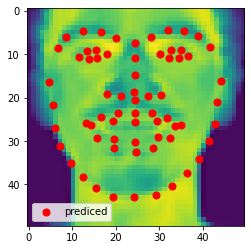

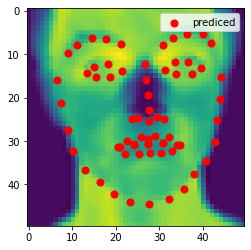

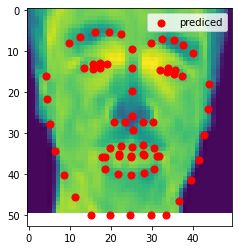

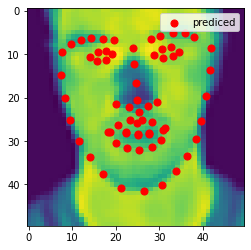

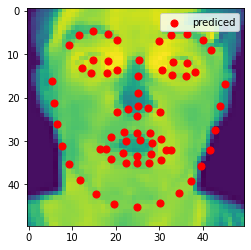

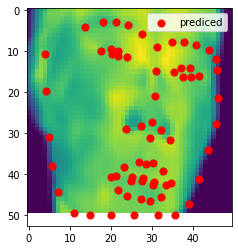

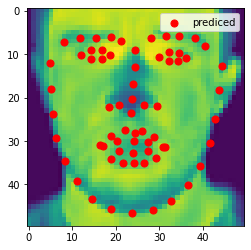

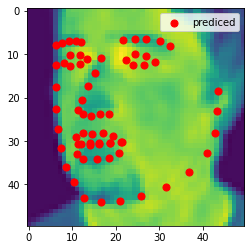

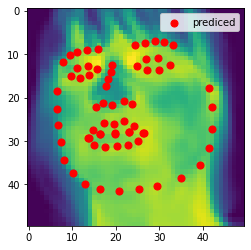

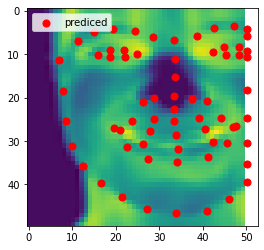

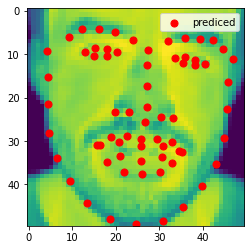

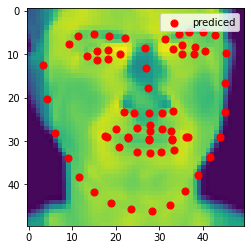

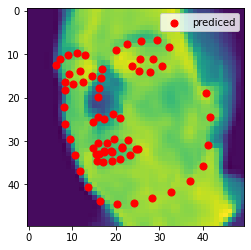

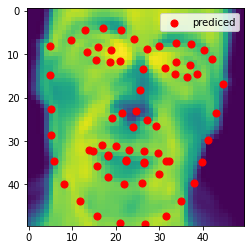

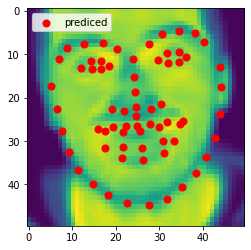

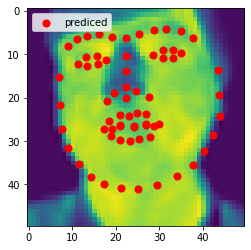

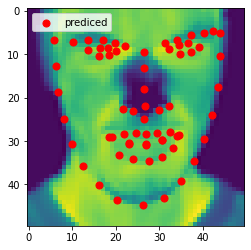

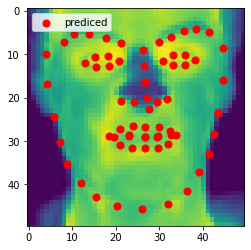

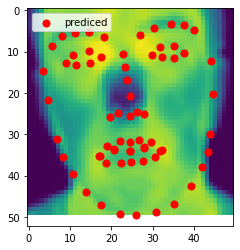

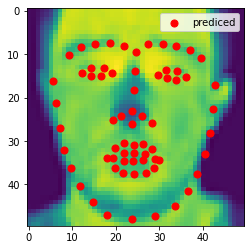

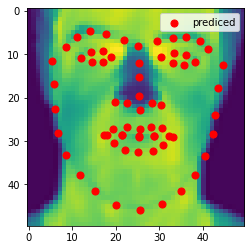

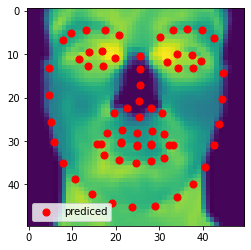

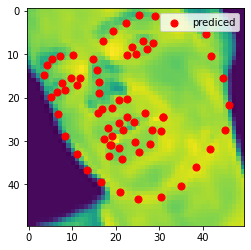

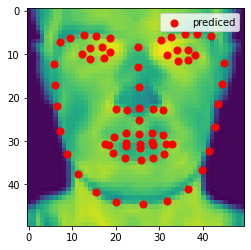

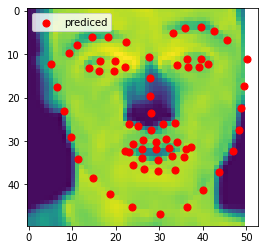

In [ ]:
  import matplotlib.pyplot as plt
  nrows = 5
  ncols = 5
  n = 0

  select = 0
  current_data = cropped[select]
  current_kp =cropped_keypoints[select]

  irand=(np.random.choice(current_data.shape[0],nrows * ncols))
  for row in range(nrows):
    for col in range(ncols):
      to_image = np.reshape(current_data[irand[n]], (50, 50)) * 255
      plt.imshow(to_image)
      new_pred = current_kp[irand[n]]
      plt.scatter(new_pred[:68] * 50, new_pred[68:] * 50, color = 'red', label = 'prediced', s = 50)
      n += 1
         
      plt.legend()
      plt.show()

(10100, 50, 50, 1)
(10100, 136)
(435, 50, 50, 1)
(435, 136)
(480, 50, 50, 1)
(480, 136)
0.039798733800908204


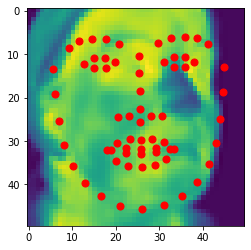

In [ ]:
mean_keypoints = np.mean(cropped_keypoints[0], axis = 0)
plt.imshow(cropped[0][0].reshape((50,50)))
plt.scatter(mean_keypoints[:68] * 50, mean_keypoints[68:] * 50, color = 'red', label = 'prediced', s = 50)
diff_cropped_keypoints = [np.zeros((data[j].shape[0], 136)) for j in range(3)]


for i in range(3):
  diff_cropped_keypoints[i] = cropped_keypoints[i] - mean_keypoints
  
for i in range(3):
  print(cropped[i].shape)
  print(diff_cropped_keypoints[i].shape)

print(np.mean(np.abs(diff_cropped_keypoints[2])))


In [ ]:
np.save('mean_kp.npy', mean_keypoints)

Epoch 1/1000
165/165 [==============================] - 3s 13ms/step - loss: 0.0620 - val_loss: 0.0373
Epoch 2/1000
165/165 [==============================] - 2s 10ms/step - loss: 0.0496 - val_loss: 0.0364
Epoch 3/1000
165/165 [==============================] - 2s 10ms/step - loss: 0.0494 - val_loss: 0.0361
Epoch 4/1000
165/165 [==============================] - 2s 10ms/step - loss: 0.0489 - val_loss: 0.0352
Epoch 5/1000
165/165 [==============================] - 2s 10ms/step - loss: 0.0476 - val_loss: 0.0333
Epoch 6/1000
165/165 [==============================] - 2s 9ms/step - loss: 0.0434 - val_loss: 0.0299
Epoch 7/1000
165/165 [==============================] - 2s 10ms/step - loss: 0.0379 - val_loss: 0.0295
Epoch 8/1000
165/165 [==============================] - 2s 10ms/step - loss: 0.0350 - val_loss: 0.0278
Epoch 9/1000
165/165 [==============================] - 2s 10ms/step - loss: 0.0325 - val_loss: 0.0259
Epoch 10/1000
165/165 [==============================] - 2s 9ms/step - los

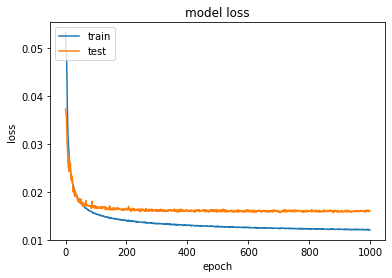

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K


model3 = Sequential()
model3.add(Conv2D(32, (2, 2), padding = 'same', activation='tanh', input_shape=(50, 50, 1)))

model3.add(Conv2D(32, (2, 2), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.5))
model3.add(Conv2D(64, (3, 3), activation='tanh'))
model3.add(Dropout(0.5))
model3.add(Conv2D(64, (3, 3), activation='tanh'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='tanh'))
model3.add(MaxPool2D(pool_size=(2, 2)))

#model3.add(Conv2D(256, (5, 5), activation='sigmoid'))



model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(68 * 2, activation='tanh'))

sgd = Adam(lr=1e-4)
model3.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=sgd) 
history = model3.fit(np.concatenate((cropped[0], cropped[1]), axis = 0), np.concatenate((diff_cropped_keypoints[0], diff_cropped_keypoints[1]), axis = 0) , batch_size=64, epochs=1000, validation_data = (cropped[2], diff_cropped_keypoints[2]), verbose = 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

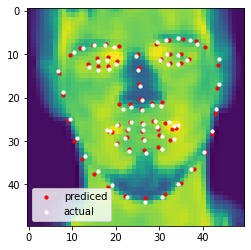

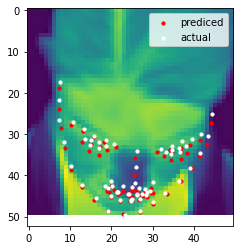

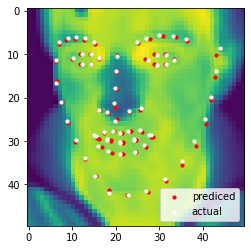

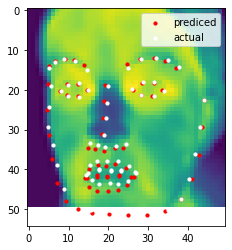

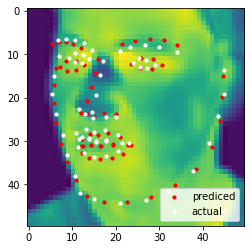

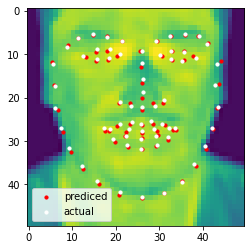

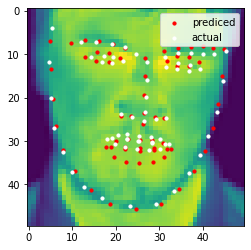

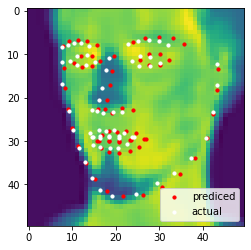

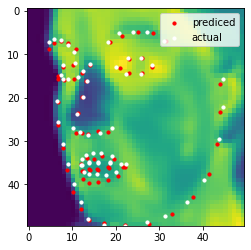

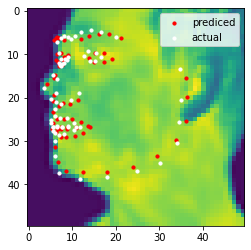

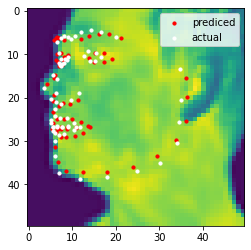

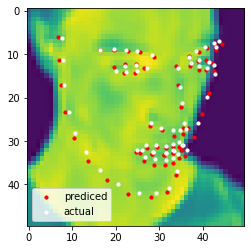

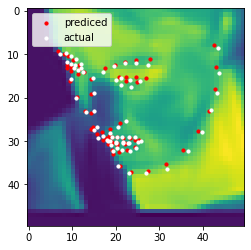

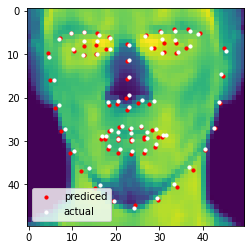

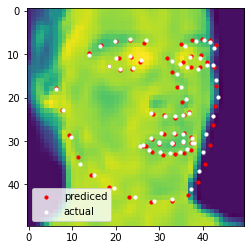

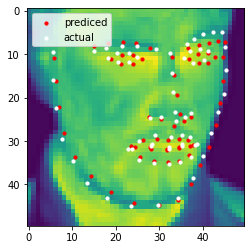

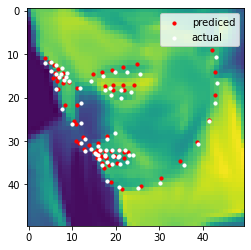

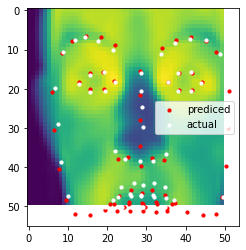

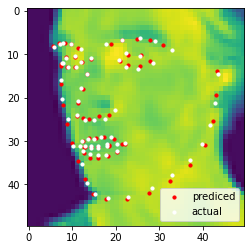

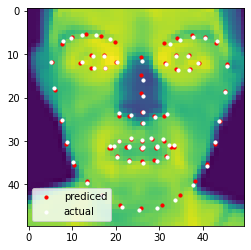

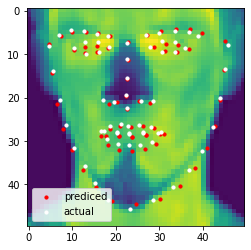

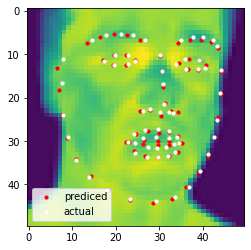

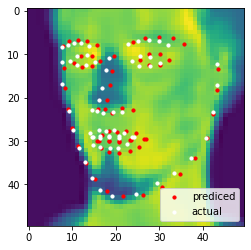

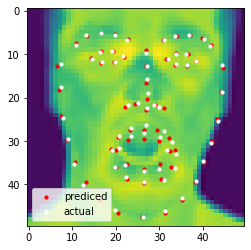

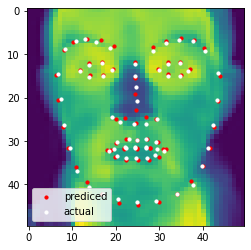

In [ ]:
pred_cropped_keypoints = [np.zeros((data[j].shape[0], 136)) for j in range(3)]
predictions_keypoints = [np.zeros((data[j].shape[0], 136)) for j in range(3)]

import random

for i in range(3):
  pred_cropped_keypoints[i] = model3.predict(cropped[i]) + mean_keypoints

for j in range(3):
  for i in range(data[j].shape[0]):
    x1, x2, y1, y2 = predictions[j][i]
    w = abs(x2 - x1) * SIZE_X
    h = abs(y2 - y1) * SIZE_Y

    predictions_keypoints[j][i, :68] = ((pred_cropped_keypoints[j][i, :68] * w) + (x1 * SIZE_X))/SIZE_X
    predictions_keypoints[j][i, 68:] = ((pred_cropped_keypoints[j][i, 68:] * h) + (y1 * SIZE_Y))/SIZE_Y


for i in range(25):
  data_num = random.randint(0, 2)
  img_num = random.randint(0, 100)
  plt.imshow(cropped[data_num][img_num].reshape((50,50)))
  plt.scatter(pred_cropped_keypoints[data_num][img_num][:68] * 50, pred_cropped_keypoints[data_num][img_num][68:] * 50, color = 'red', label = 'prediced', s = 10)
  plt.scatter(cropped_keypoints[data_num][img_num][:68] * 50, cropped_keypoints[data_num][img_num][68:] * 50, color = 'white', label = 'actual', s = 10)
  plt.legend()
  plt.show()

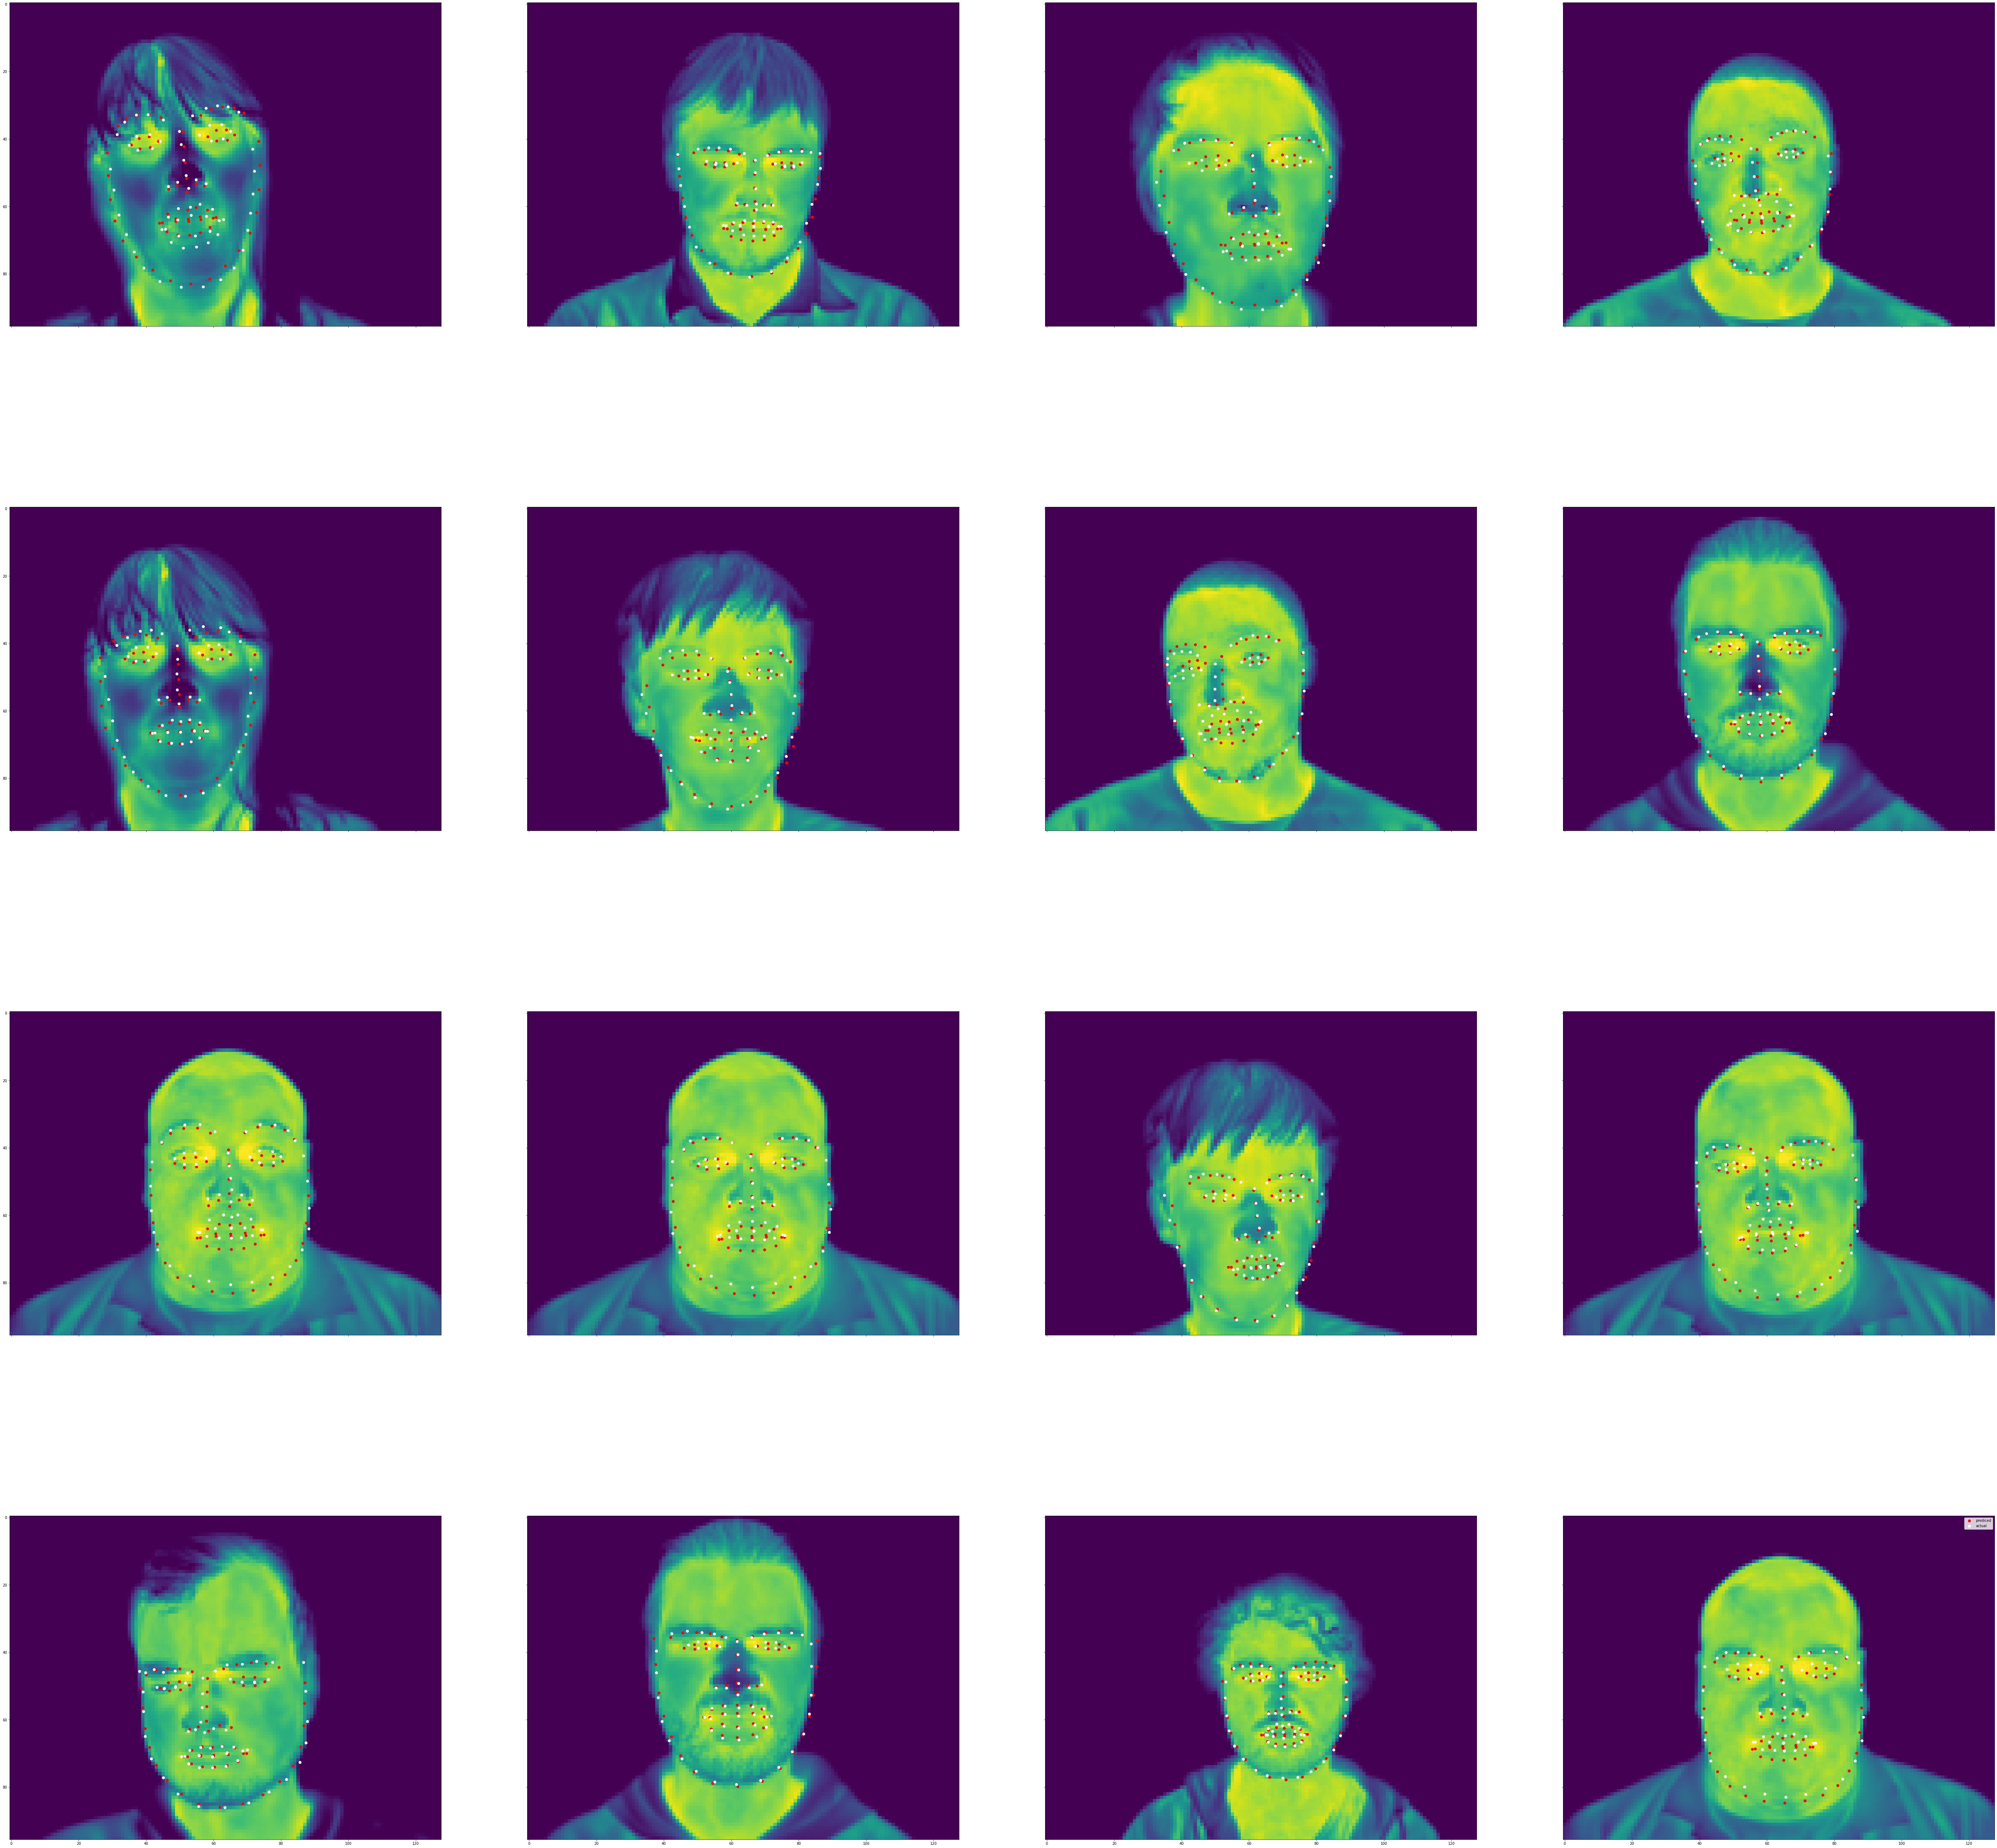

In [ ]:
def plot_predictions(predicted_set):
  n = 0
  nrows = 4
  ncols = 4
  irand=np.random.choice(test_y.shape[0],nrows*ncols)
  fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[100,100])
  for row in range(nrows):
    for col in range(ncols):

      to_image = np.reshape(test_x[irand[n]], (SIZE_Y, SIZE_X)) * 255
      ax[row,col].imshow(to_image)

      # Create a Rectangle patch
      predicted = list(predicted_set[irand[n]])
      ax[row,col].scatter([i * SIZE_X for i in predicted[:68]], [i * SIZE_Y for i in predicted[68:]],  color = 'red', label = 'prediced', s = 50)

      predicted = list(test_y[irand[n]])
      ax[row,col].scatter([i * SIZE_X for i in predicted[:68]], [i * SIZE_Y for i in predicted[68:]], color = 'white', label = 'actual', s = 50)
      n += 1
         
  plt.legend()
  plt.show()

def root_mean_squared_error(y_true, y_pred):
  return np.sqrt(K.mean(K.square(y_pred - y_true)))

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[2], boxB[2])
	xB = min(boxA[1], boxB[1])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
	boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def intersection_over_union_set(setA, setB):
  iou = []
  n = setA.shape[0]
  assert setA.shape[0] == setB.shape[0]
  for i in range(n):
    b = root_mean_squared_error(setA[i], setB[i])
    iou.append(b)

  x = [i * 0.001 for i in range(1, 100)]
  y = [sum([1 for i in iou if i < selected_x])/len(iou) for selected_x in x]
  
  plt.plot(x, y, marker = 'o')
  plt.xlim((0, 0.10))
  plt.grid()
  plt.show()

plot_predictions(predictions_keypoints[2])

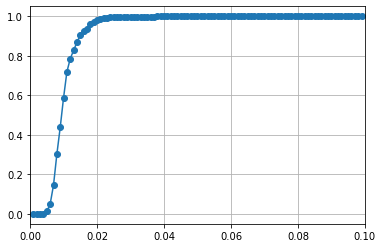

0.010852553325594805
[34, 66, 7, 71, 72, 76, 45, 14, 17, 81, 82, 25, 58, 30]


In [ ]:
y_test_pred = predictions_keypoints[2]


predictions = np.zeros((y_test_pred.shape))
actual = np.zeros((test_y.shape))
predictions[:, 0:68] = y_test_pred[:, 0:68] * SIZE_X
actual[:,0:68] =  test_y[:,0:68] * SIZE_X

predictions[:, 68:] = y_test_pred[:, 68:] * SIZE_Y
actual[:,68:] =  test_y[:,68:] * SIZE_Y

intersection_over_union_set(test_y, y_test_pred)


print(root_mean_squared_error(y_test_pred, test_y))
print(test_subjects)
model3.save_weights('./keypointsCNN_bbox.h5')